In [1]:
import os
import time
from random import choice, randint
from tqdm.notebook import tqdm

import numpy as np
import matplotlib.pyplot as plt
import pickle

from sphfile import SPHFile
import librosa
import librosa.display
import soundfile

import torch
from torch.utils.data import Dataset, DataLoader

In [2]:
def plot_spectrogram(stft, title = "Spectrogtam"):
    fig, ax = plt.subplots()
    img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft), ref=np.max), y_axis='log', x_axis='time', ax=ax)
    ax.set_title(title)
    fig.colorbar(img, ax=ax, format="%+2.0f dB")

In [3]:
def compute_stft(audio_data, win_length = 2048, hop_length = 512, n_fft = 2048):
    '''
    Helper method to compute the Short Time Fourier Transform
    '''
    return librosa.stft(audio_data, win_length=win_length, hop_length=hop_length, n_fft= n_fft)

In [6]:
# Comparing SPH data and wav data
sph_data = SPHFile('../data/000001.sph')
print(sph_data.content.shape)
print(sph_data.format['sample_sig_bits'])

wav_data, samp_rate = librosa.load('../data/000001.wav', sr= sph_data.format['sample_rate'])
print(wav_data.shape)
print(np.where(wav_data == 0))
print(np.min(wav_data), np.max(wav_data))

# print(sph_data.content/wav_data, 2**(sph_data.format['sample_sig_bits']-1))

(56789,)
16
(56789,)
(array([  151,   468,   607,   852,  1063,  1346,  1391,  1443,  1736,
        2020,  2066,  2207,  2450,  2579,  2636,  2671,  2757,  2843,
        2993,  3405,  3431,  3479,  3546,  3663,  4417,  5843,  8751,
        9551,  9721,  9770,  9885,  9918, 10118, 10235, 10322, 10424,
       15321, 15936, 16155, 17648, 18575, 18809, 19488, 19502, 19608,
       19764, 19809, 19835, 19912, 20216, 20252, 20529, 20536, 20604,
       20629, 21853, 22891, 23541, 23939, 24555, 24958, 25062, 25496,
       25840, 26261, 26272, 26331, 26650, 27057, 27079, 27181, 27198,
       27222, 27233, 27257, 27258, 27261, 27266, 27291, 27319, 27379,
       27443, 27504, 27610, 27651, 27804, 27851, 27880, 28039, 28160,
       28202, 28341, 28361, 28420, 28474, 28485, 28486, 28550, 28597,
       28985, 29021, 29102, 29109, 29402, 29406, 29599, 29609, 29638,
       29675, 29728, 30013, 30144, 30166, 30210, 33286, 33835, 34469,
       34549, 34814, 34888, 35001, 35010, 35239, 35303, 35789, 35876

In [4]:
base_dir = os.path.join(os.getcwd(), '../')
data_dir = os.path.join(os.getcwd(), '../data')
print(base_dir, data_dir)

split = 'test'
noise_list = open(os.path.join(data_dir, 'noise_list.txt')).readlines()
file_list = open(os.path.join(data_dir, '%s_set.txt'%(split))).readlines()

print(len(file_list), len(noise_list))

/home/sazim/teams/ece251c-team-11/code/../ /home/sazim/teams/ece251c-team-11/code/../data
4259 56


In [6]:
alpha = 0.8    # control noise
k = 512

clean_mixed_data_dict = {}
clean_mixed_data_dict['clean'] = []
clean_mixed_data_dict['mixed'] = []

for itr in tqdm(range(100)):
    sph_data = SPHFile(os.path.join(base_dir, file_list[itr]).rstrip())
    samp_rate = sph_data.format['sample_rate']
    print(samp_rate)

    # Randomly sample noise sample from noise data list
    noise_data = librosa.load(os.path.join(base_dir, choice(noise_list)).rstrip(), sr=samp_rate)
    assert(noise_data[1] == samp_rate)
    noise_signal = noise_data[0]

    # Mixing noise with clean speech
    clean_signal = sph_data.content / (2**(sph_data.format['sample_sig_bits']-1))

    len_signal = min(clean_signal.shape[0], noise_signal.shape[0])
    print('Length of signal -- %d' %(len_signal))
    
    start_n = randint(0, max(0, noise_signal.shape[0] - clean_signal.shape[0]))

    # randomly sample a window from noise sequence to be mixed
    noise_signal = noise_signal[start_n: start_n+len_signal]
    clean_signal = clean_signal[0:len_signal]
    mixed_signal = alpha * clean_signal + (1-alpha) * noise_signal

    # soundfile.write('mix_speech.wav', mixed_signal, SR)
    
    stft_mixed = compute_stft(mixed_signal, win_length=k, n_fft=k)
    stft_clean = compute_stft(clean_signal, win_length=k, n_fft=k)
    
    clean_mixed_data_dict['clean'].append(stft_clean)
    clean_mixed_data_dict['mixed'].append(stft_mixed)

  0%|          | 0/100 [00:00<?, ?it/s]

16000
Length of signal -- 8961
16000
Length of signal -- 8573
16000
Length of signal -- 10000
16000
Length of signal -- 79954
16000
Length of signal -- 76171
16000
Length of signal -- 9251
16000
Length of signal -- 79954
16000
Length of signal -- 214203
16000
Length of signal -- 147620
16000
Length of signal -- 89122
16000
Length of signal -- 56732
16000
Length of signal -- 31902
16000
Length of signal -- 73302
16000
Length of signal -- 109572
16000
Length of signal -- 10000
16000
Length of signal -- 48534
16000
Length of signal -- 72952
16000
Length of signal -- 60233
16000
Length of signal -- 92349
16000
Length of signal -- 80395
16000
Length of signal -- 250738
16000
Length of signal -- 82517
16000
Length of signal -- 17334
16000
Length of signal -- 149609
16000
Length of signal -- 108690
16000
Length of signal -- 70587
16000
Length of signal -- 108574
16000
Length of signal -- 16624
16000
Length of signal -- 88268
16000
Length of signal -- 8334
16000
Length of signal -- 86745
16000

In [7]:
with open(os.path.join(data_dir, 'pkl_files/train_data/clean_mixed_data.pickle'), 'wb') as handle:
    pickle.dump(clean_mixed_data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [21]:
# k = 512
# stft_mixed = compute_stft(mixed_signal, win_length=k, n_fft=k)
# stft_clean = compute_stft(clean_signal, win_length=k, n_fft=k)
# stft_noise = compute_stft(noise_signal, win_length= k, n_fft=k)
# print(stft_mixed.shape, stft_clean.shape, stft_noise.shape)

(257, 206) (257, 206) (257, 206)


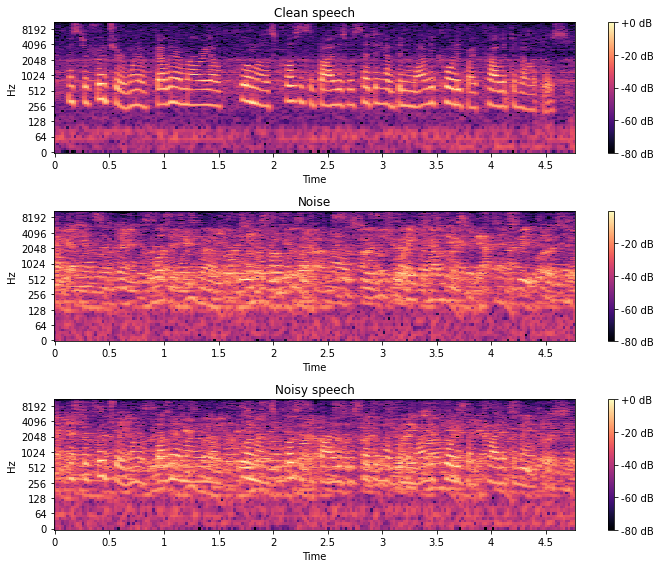

In [18]:
fig, ax = plt.subplots(3,1, figsize = (10,8))
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_clean), ref=np.max), y_axis='log', x_axis='time', ax=ax[0])
ax[0].set_title('Clean speech')
fig.colorbar(img, ax=ax[0], format="%+2.0f dB")

img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_noise), ref=np.max), y_axis='log', x_axis='time', ax=ax[1])
ax[1].set_title('Noise')
fig.colorbar(img, ax=ax[1], format="%+2.0f dB")

img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(stft_mixed), ref=np.max), y_axis='log', x_axis='time', ax=ax[2])
ax[2].set_title('Noisy speech')
fig.colorbar(img, ax=ax[2], format="%+2.0f dB")
fig.tight_layout()

Dataloader

In [2]:
def compute_stft(audio_data, win_length = 2048, hop_length = 512):
    '''
    Helper method to compute the Short Time Fourier Transform
    '''
    return librosa.stft(audio_data, win_length=win_length, hop_length=hop_length)

In [8]:
# class SpeechDataset(Dataset):
#     def __init__(self, split = 'train', alpha = 0.8):
#         assert split in ['train', 'val', 'test'], "Invalid split"
#         self.split = split
#         self.noise_list = open('data/noise_list.txt').readlines()
#         self.file_list = open('data/%s_set.txt'%(split)).readlines()
#         #(mixed = alpha*clean + (1-alpha)*noise)
#         self.alpha = alpha
    
#     def __len__(self):
#         return len(self.file_list)
    
#     def __getitem__(self, idx):
#         sph_data = SPHFile(self.file_list[idx].rstrip())
#         SR = sph_data.format['sample_rate'] # Sampling rate
#         clean_signal = sph_data.content/(2**(sph_data.format['sample_sig_bits']-1))

#         # Randomly sample noise sample from noise data list
#         noise_signal = librosa.load(choice(self.noise_list).rstrip(), sr=SR)[0]
                                  
#         len_signal = min(clean_signal.shape[0],noise_signal.shape[0])
#         # randomly sample a window from noise sequence to be mixed
#         start_n = randint(0,max(0,noise_signal.shape[0]-clean_signal.shape[0]))
#         noise_signal = noise_signal[start_n: start_n+len_signal]
#         clean_signal = clean_signal[0:len_signal]
#         mixed_signal = self.alpha*clean_signal + (1-self.alpha)*noise_signal
                                  
#         # return STFT
#         stft_mixed = compute_stft(mixed_signal)
#         stft_clean = compute_stft(clean_signal)
        
#         return stft_mixed, stft_clean

In [8]:
with open(os.path.join(data_dir, 'pkl_files/train_data/clean_mixed_data.pickle'), 'rb') as handle:
    clean_mixed_data_dict = pickle.load(handle)

In [12]:
class SpeechDataset(Dataset):
    def __init__(self, split = 'train', alpha = 0.8):
        assert split in ['train', 'val', 'test'], "Invalid split"
        self.split = split
        self.noise_list = open('../data/noise_list.txt').readlines()
        self.file_list = open('../data/%s_set.txt'%(split)).readlines()
        self.alpha = alpha
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        stft_clean = clean_mixed_data_dict['clean'][idx]
        stft_mixed = clean_mixed_data_dict['mixed'][idx]
        
        return stft_mixed, stft_clean

In [13]:
def custom_collate_fn(batch):
#     clean_spec = []
#     noisy_spec = []
#     print(len(batch))
#     for i in range(len(batch)):
#         clean_spec.append(torch.tensor(batch[i][1]))
#         noisy_spec.append(torch.tensor(batch[i][0]))

    clean_spec = [torch.tensor(batch[i][1]) for i in range(len(batch))]
    noisy_spec = [torch.tensor(batch[i][0]) for i in range(len(batch))]

    return clean_spec, noisy_spec

In [16]:
# To test dataloader
train_dataset = SpeechDataset('train')

# compute avg signal length
num_files = train_dataset.__len__()
print("Number of training files:", num_files)
# print("Avg signal length (before):", train_dataset._avg_len / 10.0)

train_dataloader = DataLoader(train_dataset, batch_size=1, collate_fn=custom_collate_fn)

start_time = time.time()
for i in tqdm(range(100)):
    clean_spec, noisy_spec = next(iter(train_dataloader))

    if i % 50 == 0:
        print("{}/{}".format(i, 1000))

print("Time taken:", round(time.time() - start_time, 3), 's')
# print("Avg signal length (after after):", train_dataset._avg_len / 10.0)

Number of training files: 49680


  0%|          | 0/100 [00:00<?, ?it/s]

0/1000
50/1000
Time taken: 0.029 s
